
# COVID-19 images - Inception V3

1. IMPORTING THE LIBRARIES

In [ ]:
import os # reading the  files
#from tensorflow.keras.preprocessing import image


import numpy as np

import cv2
import tensorflow as tf


from tensorflow.keras.preprocessing.image import ImageDataGenerator # data augmentation
import keras,os
from keras.preprocessing.image import ImageDataGenerator # keras preprocessor
import numpy as np

from keras.models import Sequential # sequential model
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten # layers we will use in the sequential model
from keras import optimizers
from keras.optimizers import Adam # model optimizer

from keras.callbacks import ModelCheckpoint, EarlyStopping # callbacks

import matplotlib.pyplot as plt # drawing plots while training and testing

import seaborn as sns
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix

import matplotlib.pyplot as plt
import os
import numpy as np
import shutil
import random

from keras.layers import Dense, Activation, Flatten, Dense,MaxPool2D, Dropout
from keras.layers import Conv2D, MaxPool2D, BatchNormalization #
from keras.callbacks import ModelCheckpoint, EarlyStopping # callbacks

 2. EXPLORING THE DATASET

Mounting the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


PATH TO FOLDERS IN GOOGLE COLAB

It seems to be a great dataset with approxiamtely 7000 images

In [ ]:
train_dir = '/content/drive/MyDrive/final_chest_x_ray/train'

valid_dir = '/content/drive/MyDrive/final_chest_x_ray/val'

test_dir = '/content/drive/MyDrive/final_chest_x_ray/val'


In [ ]:
train_normal = os.path.join(train_dir, 'normal')
train_covid = os.path.join(train_dir, 'covid')

valid_normal = os.path.join(valid_dir, 'normal')
valid_covid = os.path.join(valid_dir, "covid")

test_normal = os.path.join(test_dir, "normal")
test_covid = os.path.join(test_dir, 'covid')

In [ ]:
print('Total normal training x-ray images:', (len(os.listdir(train_normal)) + len(os.listdir(train_covid))))
print('Total validation x-ray images:', (len(os.listdir(valid_normal)) + len(os.listdir(valid_covid))))
print('Total testing x-ray images:', (len(os.listdir(test_normal)) + len(os.listdir(test_covid))))

Total normal training x-ray images: 1822
Total validation x-ray images: 298
Total testing x-ray images: 298


2. Data Augmentation 
https://keras.io/api/preprocessing/image/


The objective of ImageDataGenerator is to import data with labels easily into the model. It is a very useful class as it has many function to rescale, rotate, zoom, flip etc. The most useful thing about this class is that it doesn’t affect the data stored on the disk. 

As this one of the first data augmentation, I used the code mentioned in the keras documentaion and re-used it.

In [ ]:
#image augmentation
train_data_generator= ImageDataGenerator(rescale=1./255,
                                         zoom_range=0.2,
                                         shear_range =0.2,
                                         rotation_range =0.2,
                                         vertical_flip=True) # same as in keras documentataion 

val_data_generator= ImageDataGenerator(rescale=1./255)

test_data_generator= ImageDataGenerator(rescale=1./255)

#flow from directory
train_generator=train_data_generator.flow_from_directory(directory=train_dir, 
                                         batch_size=100, #chose a size at random
                                         target_size =(255,255), # assumed a target size
                                         shuffle=True,
                                         class_mode = 'binary')
val_generator=val_data_generator.flow_from_directory(directory=valid_dir, 
                                         batch_size=100,
                                         target_size =(255,255),
                                         shuffle=True,
                                         class_mode = 'binary')



test_generator=test_data_generator.flow_from_directory(directory=test_dir, 
                                         batch_size=100,
                                         target_size =(255,255),
                                         shuffle=True,
                                         class_mode = 'binary')
# The function ImageDataGenerator augments your image by iterating through image as your CNN is getting ready to process that image

Found 1820 images belonging to 2 classes.
Found 298 images belonging to 2 classes.
Found 298 images belonging to 2 classes.




3. Defining the transfer learning model - Inception V3


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3


# import the convolution base of the VGG16 model with pre-trained weights

base_model = InceptionV3(input_shape=(255,255,3), 
                                        include_top=False,
                                        weights='imagenet')

In [ ]:
#Adding layers to base model of MobileNet

model = Sequential()

#Creating base layer of mobilnet
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())

#Adding the Dense Layers and Dropout
model.add(Dense(512,activation=('relu'))) 

model.add(Dense(256,activation=('relu'))) 

model.add(Dropout(.3))

model.add(Dense(128,activation=('relu')))

model.add(Dropout(.2))

model.add(Dense(1,activation=('sigmoid')))

In [ ]:
#Visualizing Model Summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
dropout_3 (Dropout)          (None, 6, 6, 2048)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 73728)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               37749248  
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

DEFINING THE CALLBACKS

In [ ]:
model_name = "best_model.h5"
#CALLBACK - 1 - early_stop
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy' , patience = 5) 
'''EarlyStopping helps us to stop the training of the model early if there is no increase 
in the parameter which I have set to monitor in EarlyStopping. In this case I am monitoring validation 
accuracy by passing val_acc to EarlyStopping. I have here set patience to 5 which means that the model 
will stop to train if it doesn’t see any rise in validation accuracy in 5 epochs.'''
# if for 5 epochs the val_acc does not improve the training is going to be intereppupted
#patience is how long the model is going to train without interuppting

#CALLBACK - 2 - monitor
monitor = tf.keras.callbacks.ModelCheckpoint (model_name, monitor = 'val_accuracy',save_best_only = True , save_weights_only = True )
# you save the best model and the weights
#the callback is going the keep on checking the validation error and if the validation error decreases then we will save the model as the best model
# mode is whether u wabnt to save the minimum or maximum value of the cost function, we are not defining mode as it is automatically defined defined by tf
'''
ModelCheckpoint helps us to save the model by monitoring a specific parameter of the model. 
In this case I am monitoring validation accuracy by passing val_acc to ModelCheckpoint. 
The model will only be saved to disk if the validation accuracy of the model in current 
epoch is greater than what it was in the last epoch.
'''

#CALLBACK - 3 - lr_schedule
def scheduler(epoch, lr):
  if epoch%10==0:  #every 10 epoch reduce the learning rate by a factor of 2 
    lr = lr/2
  return lr
  
lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)# definding the callback

In [ ]:
#Compiling Model using Adam

model.compile(loss = 'binary_crossentropy', optimizer = 'adam',
              metrics = ['accuracy'])

In [ ]:
hist = model.fit_generator(steps_per_epoch=7,generator=train_generator, validation_data= val_generator, epochs=200,verbose = 1,callbacks = [early_stop, monitor, lr_schedule],  shuffle = True)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
7/7 [==============================] - 34s 4s/step - loss: 1.6627 - accuracy: 0.5848 - val_loss: 2.1362 - val_accuracy: 0.8087
Epoch 2/200
7/7 [==============================] - 24s 3s/step - loss: 0.1566 - accuracy: 0.9501 - val_loss: 0.8671 - val_accuracy: 0.8725
Epoch 3/200
7/7 [==============================] - 23s 4s/step - loss: 0.0725 - accuracy: 0.9800 - val_loss: 1.1388 - val_accuracy: 0.8960
Epoch 4/200
7/7 [==============================] - 22s 3s/step - loss: 0.0485 - accuracy: 0.9822 - val_loss: 2.2953 - val_accuracy: 0.8725
Epoch 5/200
7/7 [==============================] - 24s 3s/step - loss: 0.0897 - accuracy: 0.9939 - val_loss: 2.1306 - val_accuracy: 0.8691
Epoch 6/200
7/7 [==============================] - 23s 3s/step - loss: 0.0050 - accuracy: 0.9996 - val_loss: 1.2101 - val_accuracy: 0.8893
Epoch 7/200
7/7 [==============================] - 24s 3s/step - loss: 0.0254 - accuracy: 0.9926 - val_loss: 0.9553 - val_accuracy: 0.9228
Epoch 8/200
7/7 [==========

PLOTTING THE TEST AND VALIDATION ACCURCIES AND LOSES

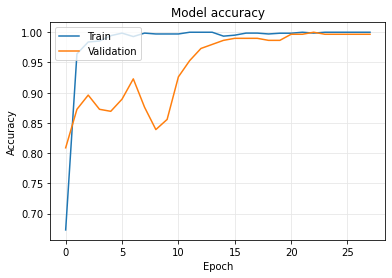

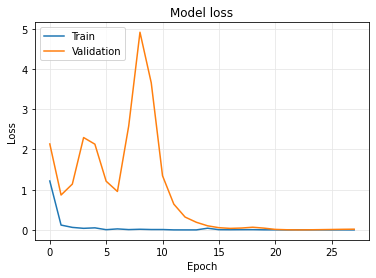

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(color='#e6e6e6')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(color='#e6e6e6')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

7.TESTING THE MODEL ON THE TEST SET AND EXTRACTING RELEVANT METRICS

In [ ]:
model.evaluate(test_generator)

3/3 [==============================] - 4s 1s/step - loss: 0.0185 - accuracy: 0.9966


[0.018526338040828705, 0.9966443181037903]

In [ ]:
model.load_weights(model_name) # here the weight we have produced during model training
metrics = model.evaluate(test_generator) # it will return the loss and metrics when we are testing the model # here we have categorical cross entropy here is loss and accuracy is the metrics
#print(metrics) # in step 4 we stated that we want to measure and monitor two metrics
print("Binary cross-entropy:" , metrics[0])
print("Accuracy:" , metrics[1])

3/3 [==============================] - 4s 1s/step - loss: 0.0013 - accuracy: 1.0000
Binary cross-entropy: 0.001252247835509479
Accuracy: 1.0


The model is fully conveged and has an accuracy of 96% and a loss of 0.58.

CONFUSION MATRIX

In [ ]:
y_pred = model.predict_generator(test_generator)
y_true = test_generator.classes
y_pred = y_pred > 0.5

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


              precision    recall  f1-score   support

       covid       0.25      0.25      0.25        57
      normal       0.82      0.82      0.82       241

    accuracy                           0.71       298
   macro avg       0.53      0.53      0.53       298
weighted avg       0.71      0.71      0.71       298



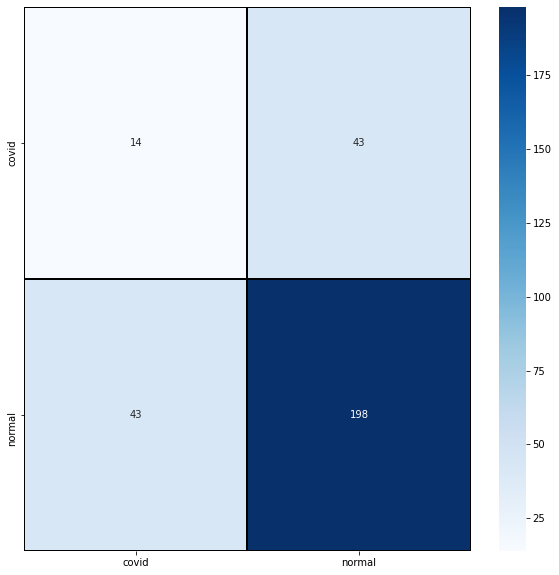

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sns

# classification report
target_names = train_generator.class_indices

print(classification_report(y_true, y_pred, target_names=target_names))

# confusion matrix
mat = confusion_matrix(y_true, y_pred)
cm = pd.DataFrame(mat, index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , 
            annot = True, fmt='',xticklabels = target_names, yticklabels = target_names)